In [52]:
import torch
import numpy as np
import gym
import PIL
from torch import nn
from tqdm.notebook import tqdm
import random
import collections

In [8]:
!pwd

Der Befehl "pwd" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


## find a propper resolution in space and time

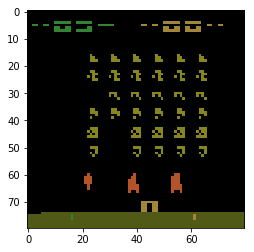

In [9]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import time
%matplotlib inline

SPACE_RES = (80,80)
TIME_RES = 3

def resize(obs):
    return np.array(PIL.Image.fromarray(obs).resize(SPACE_RES)) # , PIL.Image.BILINEAR)

def sample_steps(action, env, sample_size):
    samples = []
    info = []
    done = False
    reward = 0
    for i in range(sample_size):
 
        (_, r, d, i) = env.step(action)
        samples.append(env.render(mode='rgb_array'))
        done = done or d
        reward += r
        info = i
    
    obs = np.mean(samples, axis=0).astype('uint8')
#    obs = samples[0]
    return obs, reward, info, done
        

env = gym.make('SpaceInvaders-v0')
env.reset()
obs = resize(env.render(mode='rgb_array'))
img = plt.imshow(obs)
done = False
for i in range(200):
    time.sleep(0.01*TIME_RES)
    action = env.action_space.sample()
    obs, r, _, done = sample_steps(action, env, TIME_RES)
    obs = resize(obs)
    img.set_data(obs)
    display.display(plt.gcf())
    display.clear_output(wait=True)


## define torch value function  cnn

In [10]:
class ValueNet(nn.Module):
    def __init__(self):
        super(ValueNet, self).__init__()
        self.feat1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.feat2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.classify = nn.Sequential(
            nn.Linear(20 * 20 * 64, 100),
            nn.ReLU(),
            nn.Linear(100, 6)
        )
        self.out = nn.Tanh()
        
    def forward(self, x):
        out = self.feat1(x)
        out = self.feat2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.classify(out)
        #out = self.out(out)
        return out

In [36]:
def obs2tensor(obs):
    x = torch.FloatTensor(obs).cuda()
    x = (x - x.mean()) / x.std()
    x = x.unsqueeze(0)
    x = x.permute(0,3,1,2)
    return x
net = ValueNet()
net(obs2tensor(obs))
obs2tensor(obs).shape

torch.Size([1, 3, 80, 80])

## define gluon ValueNet

In [58]:
from mxnet import gluon

## define game state Memory

In [37]:
from collections import namedtuple
MemRow = namedtuple('MemRow', ['action', 'obs', 'reward', 'done', 'next_obs'])



In [38]:
def sample_batch(memory, batch_size):
    samples = min(batch_size, len(memory))
    return random.sample(memory, samples)

## define QFunction

In [39]:
def q_func(value_net, reward, next_obs, discount=0.9):
    q = reward + discount * value_net(next_obs)
    return q

In [40]:
def calculate_q_values(value_net, observation, next_observations, action, rewards, dones, discount=0.9):
    actual_rewards = value_net(observation)
    expected_rewards = value_net(next_observations)
    best_reward = expected_rewards.max(axis=1)[0]
    actual_rewards[:, action] = rewards + discount * best_reward * (1 - dones)
    return actual_rewards

calculate_q_values(net, obs2tensor(obs), obs2tensor(obs), torch.tensor([1]), torch.tensor([1]), torch.tensor([0]))

tensor([[-0.2407,  1.1514,  0.1452,  0.0470,  0.0977, -0.1930]],
       grad_fn=<CopySlices>)

### debug qfunction

In [41]:
value_net, observation, next_observations, action, rewards, dones, discount= (net, obs2tensor(obs), obs2tensor(obs), torch.tensor([1]), torch.tensor([1]), torch.tensor([0]), 0.9)
actual_rewards = value_net(observation)
expected_rewards = value_net(next_observations)
best_reward = expected_rewards.max(axis=1)[0]
actual_rewards[:, action] = rewards + discount * best_reward * (1 - dones)
actual_rewards

tensor([[-0.3670,  1.2285,  0.0778,  0.0074,  0.0824, -0.1062]],
       grad_fn=<CopySlices>)

In [42]:
import torch.optim as optim
import torch.nn as nn
net = ValueNet()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## train value net

In [43]:
def train_model(model, memory_batch):
    observations = torch.cat([obs2tensor(m.obs) for m in memory_batch], dim=0)
    next_observations = torch.cat([obs2tensor(m.next_obs) for m in memory_batch], dim=0)
    rewards = torch.tensor([m.reward for m in memory_batch])
    dones = torch.tensor([1 * m.done for m in memory_batch])
    batch_size = len(memory_batch)
    actions = torch.tensor([m.action for m in memory_batch])

    q_values = calculate_q_values(model, observations, next_observations, actions, rewards, dones)

    optimizer.zero_grad()
    output = model(observations)
    loss = criterion(output, q_values)
    loss.backward()
    optimizer.step()
    train_loss = loss.item()
    return train_loss
torch.autograd.set_detect_anomaly(False)
#net = ValueNet()
memory = [MemRow(obs=obs,
                 reward=1,
                 done=done,
                 next_obs=obs,
                 action=action)]
train_model(net, sample_batch(memory, 1))

0.29717618227005005

## policy function

In [44]:
def policy(value_net, obs):
    return value_net(obs).argmax().item()

policy(net, obs2tensor(obs))

3

In [45]:
from io import BytesIO
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import base64

def plotdesc(fig, text, iwidth=None):
    bio = BytesIO()
    # save fig as png to bytes IO instead to disk
    fig.savefig(bio, format='png')
    plt.close(fig)
    iwidth = ' width={0} '.format(iwidth) if iwidth is not None else ''
    img_tag = "<img src='data:image/png;base64," + base64.b64encode(bio.getvalue()) + "'{0}/>".format(iwidth)
    datatable = '<table><tr><td>{0}</td><td>{1}</td></tr></table>'.format(img_tag, text)
    display(HTML(datatable))

## use cuda

In [46]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
net = ValueNet()
net = net.cuda()

In [55]:
obs_window_length = 200
memory = collections.deque([], obs_window_length)

## Run Training

KeyboardInterrupt: 

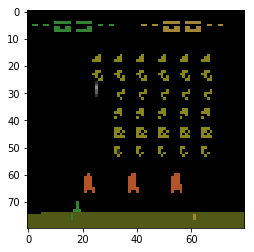

In [57]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import time
import random
%matplotlib inline

GAMES = 40

env = gym.make('SpaceInvaders-v0')
for game in range(GAMES):
    game_score = 0
    lives = 3
    done = False
    env.reset()
    obs = resize(env.render(mode='rgb_array'))
    img = plt.imshow(obs)
    while not done:
        #time.sleep(0.02*TIME_RES)
        if random.random() > 0.9:
            action = env.action_space.sample()
        else:
            action = policy(net, obs2tensor(obs))
        next_obs, score, info, done = sample_steps(action, env, TIME_RES)
        game_score += score
        reward = score/200
        next_obs = resize(next_obs)
        
        memory.append(MemRow(obs=obs,
                         reward=reward,
                         done=done,
                         next_obs=next_obs,
                         action=action))
        if info['ale.lives'] < lives:
            lives = info['ale.lives']
            reward = -1

        img.set_data(obs)
        display.display(plt.gcf())
        loss = train_model(net, sample_batch(memory, 10))
        print(f'{game}) loss: {loss}')
        display.clear_output(wait=True)
        obs = next_obs

print(loss)